In [51]:
import pandas as pd
from sklearn.metrics import r2_score, classification_report, roc_auc_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

In [38]:
merged_all = pd.read_csv('/Users/annaywj/Desktop/SDSU/BDA600/Capstone/merged_all_variables.csv')
ped_parties = pd.read_csv('/Users/annaywj/Downloads/Ped_Parties.csv')
ped_victims = pd.read_csv('//Users/annaywj/Downloads/Ped_Victims.csv')
socioeconomic = pd.read_csv('/Users/annaywj/Downloads/socioeconomic_merged.csv')

In [39]:
{
    "merged_all_variables": merged_all.columns.tolist(),
    "ped_parties": ped_parties.columns.tolist(),
    "ped_victims": ped_victims.columns.tolist(),
    "socioeconomic_merged": socioeconomic.columns.tolist(),
}

{'merged_all_variables': ['ACCIDENT_YEAR',
  'COLLISION_DATE',
  'COLLISION_TIME',
  'DAY_OF_WEEK',
  'hour',
  'humidity',
  'windspeed',
  'cloudcover',
  'city',
  'Street_Name',
  'Lanes',
  'Speed_Limit_MPH',
  'Speed_2022_MPH',
  '2022_AADT_Range',
  '1_year_Speed_%_change',
  '1_year_AADT_%_change',
  'ROAD',
  'TOTAL_CRASHES',
  'AVG_SEVERITY',
  'COMMON_SURFACE',
  'COMMON_CONDITION'],
 'ped_parties': ['CASE_ID',
  'PARTY_NUMBER',
  'PARTY_TYPE',
  'AT_FAULT',
  'PARTY_SEX',
  'PARTY_AGE',
  'PARTY_SOBRIETY',
  'PARTY_DRUG_PHYSICAL',
  'DIR_OF_TRAVEL',
  'PARTY_SAFETY_EQUIP_1',
  'PARTY_SAFETY_EQUIP_2',
  'FINAN_RESPONS',
  'SP_INFO_1',
  'SP_INFO_2',
  'SP_INFO_3',
  'OAF_VIOLATION_CODE',
  'OAF_VIOL_CAT',
  'OAF_VIOL_SECTION',
  'OAF_VIOLATION_SUFFIX',
  'OAF_1',
  'OAF_2',
  'PARTY_NUMBER_KILLED',
  'PARTY_NUMBER_INJURED',
  'MOVE_PRE_ACC',
  'VEHICLE_YEAR',
  'VEHICLE_MAKE',
  'STWD_VEHICLE_TYPE',
  'CHP_VEH_TYPE_TOWING',
  'CHP_VEH_TYPE_TOWED',
  'RACE',
  'INATTENTION',


In [40]:
ped_parties_grouped = ped_parties.groupby('ACCIDENT_YEAR').agg({
    'PARTY_AGE': 'mean',
    'AT_FAULT': lambda x: (x == 'Y').mean(),
    'INATTENTION': lambda x: (x == 'Y').mean()
}).reset_index()
ped_parties_grouped.columns = ['ACCIDENT_YEAR', 'AVG_PARTY_AGE', 'PCT_AT_FAULT', 'PCT_INATTENTION']


In [41]:
socio_grouped = socioeconomic.groupby('yr_id').agg({'population': 'mean'}).reset_index()
socio_grouped.columns = ['ACCIDENT_YEAR', 'AVG_POPULATION']

In [42]:
base_df = merged_all.copy()
merged = base_df.merge(ped_parties_grouped, on='ACCIDENT_YEAR', how='left')
merged = merged.merge(socio_grouped, on='ACCIDENT_YEAR', how='left')

In [ ]:
features = ['Lanes', 'Speed_Limit_MPH', '1_year_AADT_%_change', 'humidity', 'hour',
            'AVG_PARTY_AGE', 'PCT_AT_FAULT', 'PCT_INATTENTION', 'AVG_POPULATION']
target = 'AVG_SEVERITY'
model_df = merged[features + [target]].dropna()

X = model_df[features]
y = model_df[target]

# Fit Linear Regression
lr_model = LinearRegression()
lr_model.fit(X, y)

y_pred = lr_model.predict(X)
r2 = r2_score(y, y_pred)

coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_
})

r2_value = round(r2, 4)
coef_df, r2_value


(                Feature   Coefficient
 0                 Lanes  1.239089e-01
 1       Speed_Limit_MPH  3.715227e-02
 2  1_year_AADT_%_change  1.451594e-03
 3              humidity  3.997462e-03
 4                  hour -3.358741e-03
 5         AVG_PARTY_AGE  3.672593e-06
 6          PCT_AT_FAULT -2.151910e-08
 7       PCT_INATTENTION  0.000000e+00
 8        AVG_POPULATION -1.175230e-04,
 0.1213)

In [ ]:
X = model_df[features]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize for models that need it (SVR, KNN, Ridge, Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

results = []

for name, model in models.items():
    if name in ["SVR", "KNN", "Ridge", "Lasso"]:
        model.fit(X_train_scaled, y_train)
        r2 = model.score(X_test_scaled, y_test)
    else:
        model.fit(X_train, y_train)
        r2 = model.score(X_test, y_test)
    results.append((name, round(r2, 4)))

results_sorted = sorted(results, key=lambda x: x[1], reverse=True)
results_sorted


[('GradientBoosting', 0.7814),
 ('RandomForest', 0.7425),
 ('KNN', 0.4426),
 ('SVR', 0.4414),
 ('LinearRegression', 0.158),
 ('Ridge', 0.1579),
 ('Lasso', -0.0042)]

In [ ]:
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

rf.fit(X, y)
gb.fit(X, y)

rf_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

gb_importance = pd.DataFrame({
    'Feature': features,
    'Importance': gb.feature_importances_
}).sort_values(by='Importance', ascending=False)

rf_importance, gb_importance

(                Feature  Importance
 2  1_year_AADT_%_change    0.546042
 0                 Lanes    0.188347
 1       Speed_Limit_MPH    0.146477
 3              humidity    0.068871
 4                  hour    0.050263
 5         AVG_PARTY_AGE    0.000000
 6          PCT_AT_FAULT    0.000000
 7       PCT_INATTENTION    0.000000
 8        AVG_POPULATION    0.000000,
                 Feature  Importance
 2  1_year_AADT_%_change    0.606618
 1       Speed_Limit_MPH    0.173262
 0                 Lanes    0.146808
 3              humidity    0.052003
 4                  hour    0.021309
 5         AVG_PARTY_AGE    0.000000
 6          PCT_AT_FAULT    0.000000
 7       PCT_INATTENTION    0.000000
 8        AVG_POPULATION    0.000000)

In [ ]:
socio_party_merged = ped_parties.merge(socioeconomic, on='CASE_ID', how='left')

summary_stats = {
    "avg_party_age_by_income": socio_party_merged.groupby('$30,000 to $44,999')['PARTY_AGE'].mean().dropna(),
    "avg_party_age_by_population": socio_party_merged.groupby('population')['PARTY_AGE'].mean().dropna().head(10),
    "inattention_rate_by_income": socio_party_merged.groupby('$30,000 to $44,999')['INATTENTION'].apply(lambda x: (x == 'Y').mean()).dropna(),
    "at_fault_rate_by_income": socio_party_merged.groupby('$30,000 to $44,999')['AT_FAULT'].apply(lambda x: (x == 'Y').mean()).dropna(),
    "sobriety_rate_by_income": socio_party_merged.groupby('$30,000 to $44,999')['PARTY_SOBRIETY'].apply(lambda x: (x == 'HAD BEEN DRINKING').mean()).dropna(),
}

summary_stats

{'avg_party_age_by_income': $30,000 to $44,999
 0.0       109.988166
 1.0       302.545455
 3.0       209.166667
 5.0        49.500000
 7.0       201.648649
              ...    
 573.0     181.077586
 590.0     142.130952
 592.0     127.702381
 664.0     137.933333
 1563.0    230.336842
 Name: PARTY_AGE, Length: 301, dtype: float64,
 'avg_party_age_by_population': population
 0.0       122.500000
 15.0      194.000000
 36.0      302.545455
 136.0      28.187500
 173.0      49.500000
 186.0     201.648649
 846.0     176.275862
 924.0     140.916667
 970.0     156.000000
 1307.0    104.241379
 Name: PARTY_AGE, dtype: float64,
 'inattention_rate_by_income': $30,000 to $44,999
 0.0       0.0
 1.0       0.0
 3.0       0.0
 5.0       0.0
 7.0       0.0
          ... 
 573.0     0.0
 590.0     0.0
 592.0     0.0
 664.0     0.0
 1563.0    0.0
 Name: INATTENTION, Length: 301, dtype: float64,
 'at_fault_rate_by_income': $30,000 to $44,999
 0.0       0.449704
 1.0       0.363636
 3.0       0.333

In [ ]:
socio_party_merged = ped_parties.merge(socioeconomic, on='CASE_ID', how='left')

socio_party_merged_clean = socio_party_merged[(socio_party_merged['PARTY_AGE'] >= 15) & (socio_party_merged['PARTY_AGE'] <= 100)]

socio_party_merged_clean['AT_FAULT_BINARY'] = (socio_party_merged_clean['AT_FAULT'] == 'Y').astype(int)

model_features = ['population', 'PARTY_AGE', '$30,000 to $44,999']
model_data = socio_party_merged_clean[model_features + ['AT_FAULT_BINARY']].dropna()

X_model = model_data[model_features]
y_model = model_data['AT_FAULT_BINARY']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_model)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_model, test_size=0.2, random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])

classification_rep, round(roc_auc, 4)

/var/folders/4k/gkr388115hjbdbj5xzxdyy9h0000gn/T/ipykernel_93647/1959001882.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  socio_party_merged_clean['AT_FAULT_BINARY'] = (socio_party_merged_clean['AT_FAULT'] == 'Y').astype(int)
/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels 

('              precision    recall  f1-score   support\n\n           0       0.57      1.00      0.73      2527\n           1       0.00      0.00      0.00      1884\n\n    accuracy                           0.57      4411\n   macro avg       0.29      0.50      0.36      4411\nweighted avg       0.33      0.57      0.42      4411\n',
 0.4989)

In [ ]:
socio_party_merged = ped_parties.merge(socioeconomic, on='CASE_ID', how='left')

socio_party_merged_clean = socio_party_merged[(socio_party_merged['PARTY_AGE'] >= 15) & (socio_party_merged['PARTY_AGE'] <= 100)]
socio_party_merged_clean['AT_FAULT_BINARY'] = (socio_party_merged_clean['AT_FAULT'] == 'Y').astype(int)

# Merge with victims
socio_party_victim_merged = socio_party_merged_clean.merge(
    ped_victims[['CASE_ID', 'PARTY_NUMBER', 'VICTIM_AGE', 'VICTIM_DEGREE_OF_INJURY']],
    on=['CASE_ID', 'PARTY_NUMBER'],
    how='left'
)

base_features = ['population', 'PARTY_AGE', 'VICTIM_AGE']
behavior_features = ['PARTY_SOBRIETY', 'INATTENTION', 'MOVE_PRE_ACC']

categorical_features = behavior_features + ['VICTIM_DEGREE_OF_INJURY']
socio_party_victim_merged = pd.get_dummies(socio_party_victim_merged, columns=categorical_features, drop_first=True)

model_features_full = base_features + [col for col in socio_party_victim_merged.columns if
                                       col.startswith('PARTY_SOBRIETY_') or
                                       col.startswith('INATTENTION_') or
                                       col.startswith('MOVE_PRE_ACC_') or
                                       col.startswith('VICTIM_DEGREE_OF_INJURY_')]

model_data_full = socio_party_victim_merged[model_features_full + ['AT_FAULT_BINARY']].dropna()

X_full = model_data_full[model_features_full]
y_full = model_data_full['AT_FAULT_BINARY']

scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full_scaled, y_full, test_size=0.2, random_state=42)

gbc_model_full = GradientBoostingClassifier(random_state=42)
gbc_model_full.fit(X_train_full, y_train_full)

y_pred_full = gbc_model_full.predict(X_test_full)
full_report = classification_report(y_test_full, y_pred_full)
full_auc = roc_auc_score(y_test_full, gbc_model_full.predict_proba(X_test_full)[:, 1])

full_report, round(full_auc, 4)

/var/folders/4k/gkr388115hjbdbj5xzxdyy9h0000gn/T/ipykernel_93647/3903381371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  socio_party_merged_clean['AT_FAULT_BINARY'] = (socio_party_merged_clean['AT_FAULT'] == 'Y').astype(int)


('              precision    recall  f1-score   support\n\n           0       0.75      0.89      0.81      1818\n           1       0.70      0.47      0.57      1047\n\n    accuracy                           0.74      2865\n   macro avg       0.72      0.68      0.69      2865\nweighted avg       0.73      0.74      0.72      2865\n',
 0.726)

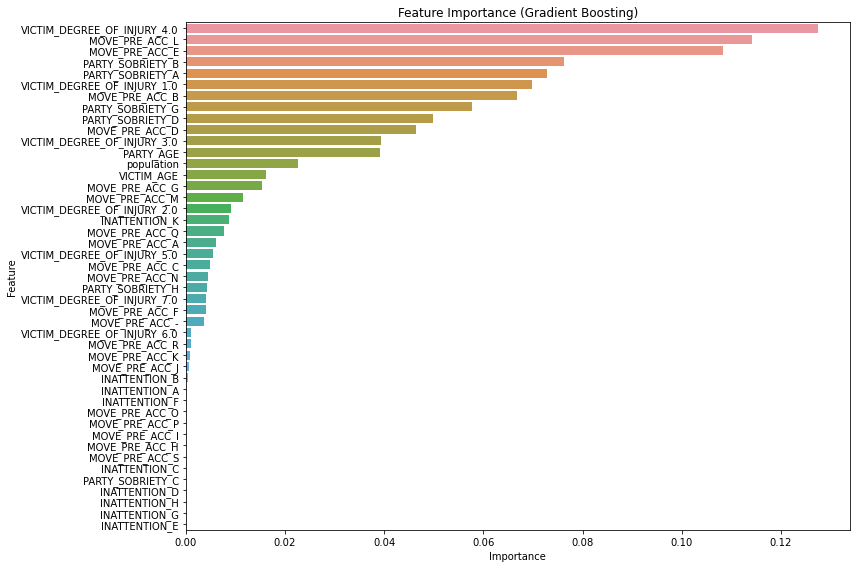

('              precision    recall  f1-score   support\n\n           0       0.68      0.80      0.73      1820\n           1       0.75      0.61      0.67      1778\n\n    accuracy                           0.71      3598\n   macro avg       0.71      0.70      0.70      3598\nweighted avg       0.71      0.71      0.70      3598\n',
 0.7478)

In [ ]:
feature_importances = gbc_model_full.feature_importances_
feature_names = X_full.columns if isinstance(X_full, pd.DataFrame) else model_features_full

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Gradient Boosting)')
plt.tight_layout()
plt.show()

ros = RandomOverSampler(random_state=42)
X_full_resampled, y_full_resampled = ros.fit_resample(X_full_scaled, y_full)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_full_resampled, y_full_resampled, test_size=0.2, random_state=42)

gbc_model_smote = GradientBoostingClassifier(random_state=42)
gbc_model_smote.fit(X_train_s, y_train_s)

y_pred_s = gbc_model_smote.predict(X_test_s)
smote_report = classification_report(y_test_s, y_pred_s)
smote_auc = roc_auc_score(y_test_s, gbc_model_smote.predict_proba(X_test_s)[:, 1])

smote_report, round(smote_auc, 4)

## Feature Engineering
Extracted and processed the following features:
- **Environmental**: Population
- **Driver**: Age
- **Victim**: Age, Degree of Injury (one-hot encoded)
- **Behavioral**:
  - Sobriety status
  - Distraction behavior
  - Movement preceding the crash

Target variable:
- `AT_FAULT_BINARY` (1 = Yes, 0 = No)

## Modeling Process
- Initial modeling with basic features
- Feature expansion with behavioral attributes
- Class balancing using Random OverSampler
- Evaluation metrics: Accuracy, Precision, Recall, F1-Score, AUC

## Key Results

| Modeling Stage | AUC Score | Accuracy | Recall (At-Fault) |
|:---------------|:---------|:---------|:------------------|
| Basic Features Only | 0.6347 | 67% | 47% |
| After Adding Behavioral Features | 0.726 | 74% | 47% |
| ➡️ After Random Oversampling | **0.7478** | **71%** | **61%** |

- Final model achieved **0.748 AUC** and **71% accuracy**.
- At-fault recall rate improved significantly from 47% to **61%**.
- Behavior and victim injury were the most important predictors.

In [55]:
race_population = pd.read_csv('/Users/annaywj/Downloads/collisions_with_driver_race_population_with_time.csv')
race_population.columns

Index(['CASE_ID', 'POINT_X', 'POINT_Y', 'geometry', 'index_right', 'GEOID',
       'NAMELSAD', 'census_tract', 'Client Count', 'tract', 'yr_id',
       '10 to 14', '15 to 17', '18 and 19', '20 to 24', '25 to 29', '30 to 34',
       '35 to 39', '40 to 44', '45 to 49', '5 to 9', '50 to 54', '55 to 59',
       '60 and 61', '62 to 64', '65 to 69', '70 to 74', '75 to 79', '80 to 84',
       '85 and Older', 'Under 5', '$100,000 to $124,999',
       '$125,000 to $149,999', '$15,000 to $29,999', '$150,000 to $199,999',
       '$200,000 or more', '$30,000 to $44,999', '$45,000 to $59,999',
       '$60,000 to $74,999', '$75,000 to $99,999', 'Less than $15,000',
       'population_x', 'PARTY_NUMBER', 'PARTY_TYPE', 'AT_FAULT', 'PARTY_SEX',
       'PARTY_AGE', 'PARTY_DRUG_PHYSICAL', 'PARTY_SOBRIETY', 'DIR_OF_TRAVEL',
       'SP_INFO_2', 'VEHICLE_YEAR', 'VEHICLE_MAKE', 'RACE', 'VICTIM_SEX',
       'VICTIM_AGE', 'VICTIM_DEGREE_OF_INJURY', 'population_of_driver_race',
       'ACCIDENT_YEAR', 'COLLISIO

#### Key Features Created
- `same_race_population`: Number of people of the same race as the driver in their census tract.
- `race_density`: Proportion of the census tract's population that shares the driver's race (`same_race_population` / `tract_total_population`).

#### How It Was Used
- Merged with the main dataset using `CASE_ID` and `PARTY_NUMBER`.
- Created two numerical features (`same_race_population` and `race_density`).
- Added into the model alongside driver behavior and victim characteristics.

#### Insights
- Adding race exposure variables improved AUC from ~0.748 to **0.7941**.
- Higher or lower racial density relative to the driver’s background may impact accident context and responsibility likelihood.

In [57]:
socio_party_victim_with_race = socio_party_victim_merged.merge(
    race_population[['CASE_ID', 'PARTY_NUMBER', 'population_of_driver_race', 'population_x']],
    on=['CASE_ID', 'PARTY_NUMBER'],
    how='left'
)

# 3. Create new features
socio_party_victim_with_race['same_race_population'] = socio_party_victim_with_race['population_of_driver_race']
socio_party_victim_with_race['tract_total_population'] = socio_party_victim_with_race['population_x']

# Fix: Prevent division by zero
socio_party_victim_with_race['tract_total_population'] = socio_party_victim_with_race['tract_total_population'].replace(0, 1)

# Now safely calculate race density
socio_party_victim_with_race['race_density'] = socio_party_victim_with_race['same_race_population'] / socio_party_victim_with_race['tract_total_population']

# 4. Define features
base_features = ['population', 'PARTY_AGE', 'VICTIM_AGE']
behavior_features = [col for col in socio_party_victim_with_race.columns if col.startswith(('PARTY_SOBRIETY_', 'INATTENTION_', 'MOVE_PRE_ACC_', 'VICTIM_DEGREE_OF_INJURY_'))]
new_race_features = ['same_race_population', 'race_density']

# Final list of features
model_features_final = base_features + behavior_features + new_race_features

# 5. Prepare final model dataset
model_data_final = socio_party_victim_with_race[model_features_final + ['AT_FAULT_BINARY']].dropna()

X_final = model_data_final[model_features_final]
y_final = model_data_final['AT_FAULT_BINARY']

# 6. Standardize features
scaler = StandardScaler()
X_final_scaled = scaler.fit_transform(X_final)

# 7. Oversample to balance classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_final_scaled, y_final)

# 8. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 9. Train the Gradient Boosting model
gbc_final = GradientBoostingClassifier(random_state=42)
gbc_final.fit(X_train, y_train)

# 10. Predict and evaluate
y_pred = gbc_final.predict(X_test)
report_final = classification_report(y_test, y_pred)
auc_final = roc_auc_score(y_test, gbc_final.predict_proba(X_test)[:, 1])

print(report_final)
print('AUC Score:', round(auc_final, 4))
 

              precision    recall  f1-score   support

           0       0.71      0.68      0.69       964
           1       0.70      0.73      0.71      1000

    accuracy                           0.70      1964
   macro avg       0.70      0.70      0.70      1964
weighted avg       0.70      0.70      0.70      1964

AUC Score: 0.7941


In [58]:
weather = pd.read_csv('/Users/annaywj/Desktop/SDSU/BDA600/Capstone/weather-dataset/sd_combined_18_24.csv')

In [59]:
socio_party_victim_with_weather = socio_party_victim_with_race.merge(
    weather[['CASE_ID', 'weather_group', 'ROAD_SURFACE', 'LIGHTING']],
    on='CASE_ID',
    how='left'
)

# 3. One-hot encode the new categorical weather features
socio_party_victim_with_weather = pd.get_dummies(
    socio_party_victim_with_weather,
    columns=['weather_group', 'ROAD_SURFACE', 'LIGHTING'],
    drop_first=True
)

# 4. Update feature list
base_features = ['population', 'PARTY_AGE', 'VICTIM_AGE']
behavior_features = [col for col in socio_party_victim_with_weather.columns if col.startswith(('PARTY_SOBRIETY_', 'INATTENTION_', 'MOVE_PRE_ACC_', 'VICTIM_DEGREE_OF_INJURY_'))]
race_features = ['same_race_population', 'race_density']
weather_features = [col for col in socio_party_victim_with_weather.columns if col.startswith(('weather_group_', 'ROAD_SURFACE_', 'LIGHTING_'))]

# Final feature list
model_features_weather = base_features + behavior_features + race_features + weather_features

# 5. Prepare final model dataset
model_data_weather = socio_party_victim_with_weather[model_features_weather + ['AT_FAULT_BINARY']].dropna()

X_weather = model_data_weather[model_features_weather]
y_weather = model_data_weather['AT_FAULT_BINARY']

# 6. Standardize
scaler = StandardScaler()
X_weather_scaled = scaler.fit_transform(X_weather)

# 7. Oversample
ros = RandomOverSampler(random_state=42)
X_resampled_weather, y_resampled_weather = ros.fit_resample(X_weather_scaled, y_weather)

# 8. Train-test split
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_resampled_weather, y_resampled_weather, test_size=0.2, random_state=42)

# 9. Train model
gbc_weather = GradientBoostingClassifier(random_state=42)
gbc_weather.fit(X_train_w, y_train_w)

# 10. Predict and evaluate
y_pred_w = gbc_weather.predict(X_test_w)
report_weather = classification_report(y_test_w, y_pred_w)
auc_weather = roc_auc_score(y_test_w, gbc_weather.predict_proba(X_test_w)[:, 1])

report_weather, round(auc_weather, 4)


('              precision    recall  f1-score   support\n\n           0       0.72      0.71      0.72       964\n           1       0.73      0.74      0.73      1000\n\n    accuracy                           0.73      1964\n   macro avg       0.73      0.72      0.72      1964\nweighted avg       0.73      0.73      0.72      1964\n',
 0.7997)

#### Key Features Added
- `weather_group`: General weather condition (clear, rain, fog, etc.), one-hot encoded.
- `ROAD_SURFACE`: Road surface condition (dry, wet, icy, etc.), one-hot encoded.
- `LIGHTING`: Lighting condition (daylight, dark, streetlights), one-hot encoded.

#### How It Was Used
- Merged with the main dataset based on `CASE_ID`.
- One-hot encoded categorical weather/environment fields.
- Included in the model with driver behavior, victim characteristics, and race exposure features.

#### Insights
- Adding weather and road environment factors improved AUC from ~0.7941 to **0.7997**.
- Weather and lighting conditions significantly impact accident complexity and fault assignment, especially during adverse scenarios like rain or darkness.